<a href="https://colab.research.google.com/github/m-tabasy/nlp_notebooks/blob/master/Inspect_mlm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Libs

In [ ]:
# @title install libs

!pip install transformers

In [21]:
# @title import libs

from transformers import AutoModelForMaskedLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt

# Load Models, Define Funcs

* You can load multiple models by running the cell below  multiple times

In [ ]:
# @title load models
models = models if 'models' in dir() else {}
tokenizers = tokenizers if 'tokenizers' in dir() else {}

model_name = "HooshvareLab/bert-base-parsbert-uncased" #@param ["bert-base-uncased", "bert-large-uncased", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large", "bert-base-multilingual-uncased", "HooshvareLab/bert-base-parsbert-uncased"]
tokenizers[model_name] = AutoTokenizer.from_pretrained(model_name)
models[model_name] = AutoModelForMaskedLM.from_pretrained(model_name)

print(list(models.keys()))

In [4]:
# @title fill mask

def fill_mask(text, k, return_full_text=True, model_name=None):

  model_name = model_name or list(models.keys())[0]
  model = models[model_name]
  tokenizer = tokenizers[model_name]

  text = text.replace('*', tokenizer.mask_token)
  input = tokenizer.encode(text, return_tensors="pt")
  mask_token_index = torch.where(input == tokenizer.mask_token_id)[1]

  token_logits = model(input)[0]
  mask_token_logits = token_logits[0, mask_token_index, :]
  token_probs = torch.softmax(mask_token_logits, -1, torch.float32).detach().numpy()[0].tolist()

  top_k_tokens = torch.topk(mask_token_logits, k, dim=1).indices[0].tolist()

  for token in top_k_tokens:
    if return_full_text:
      yield token_probs[token], text.replace(tokenizer.mask_token, f'[{tokenizer.decode([token]).strip()}]')
    else:
      yield token_probs[token], tokenizer.decode([token]).strip()
  

# Manual Inspect

* Place a "*" where you want the model to fill.
* Current fill_mask function only supports one masked token.

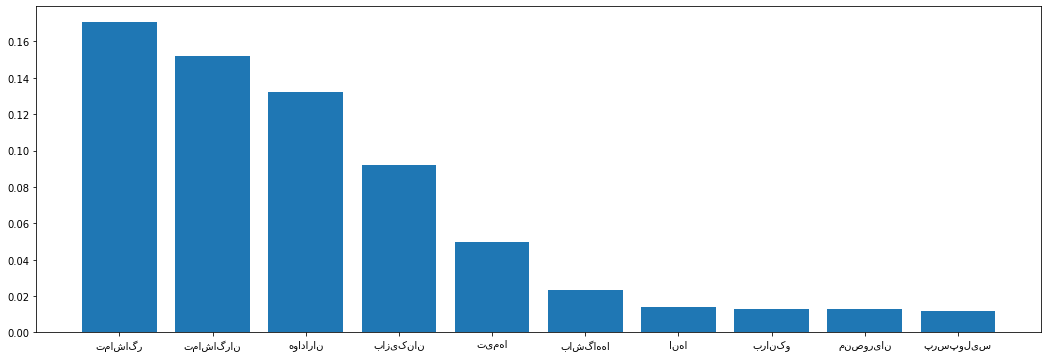

In [35]:
model_name = "HooshvareLab/bert-base-parsbert-uncased" #@param ["bert-base-uncased", "bert-large-uncased", "bert-base-cased", "bert-large-cased", "roberta-base", "roberta-large", "bert-base-multilingual-uncased", "HooshvareLab/bert-base-parsbert-uncased"]
text = "\u0628\u0627 \u0627\u06CC\u0646 \u0648\u062C\u0648\u062F \u0628\u0647 \u0646\u0638\u0631 \u0645\u06CC \u0631\u0633\u062F \u0628\u0627\u0632\u06CC \u0647\u0627\u06CC \u0644\u06CC\u06AF \u0628\u0631\u062A\u0631 \u062F\u0631 \u0641\u0635\u0644 \u062C\u062F\u06CC\u062F \u0647\u0645 \u0628\u062F\u0648\u0646 \u062D\u0636\u0648\u0631 * \u0628\u0631\u06AF\u0632\u0627\u0631 \u0645\u06CC \u0634\u0648\u062F" #@param {type:"string"}
top_k_words = 10 #@param {type:"integer"}
print_full_text = False #@param {type:"boolean"}
probs, words = [], []
plt.rcParams['figure.figsize'] = [18, 6]

for output in fill_mask(text, top_k_words, model_name=model_name, return_full_text=return_full_text):
  if print_full_text:
    print(output)
  else:
    probs.append(output[0])
    words.append(output[1])

if not print_full_text:
  plt.bar(words, probs)
  plt.show()